## Multipanel plot with profile for each site

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cmocean
import matplotlib.dates as mdates
import cmocean
# from matplotlib.lines import Line2D
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap
# import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
# from matplotlib import gridspec

In [383]:
ekman_KO = w_ek_1d.sel(latitude = 75.75, longitude = -60) * 86400 # per day
curl_KO = curl_BB_1d_scaled.sel(latitude = 75.75, longitude = -60)
ice_KO = seaice_1d_2018to2020.sel(latitude = 75.75, longitude = -60)

ekman_sverdrup = w_ek_1d.sel(latitude = 75.5, longitude = -59) * 86400 # per day
curl_sverdrup = curl_BB_1d_scaled.sel(latitude = 75.5, longitude = -59)
ice_sverdrup = seaice_1d_2018to2020.sel(latitude = 75.5, longitude = -59)

ekman_rink = w_ek_1d.sel(latitude = 76, longitude = -61.25) * 86400 # per day
curl_rink = curl_BB_1d_scaled.sel(latitude = 76, longitude = -61.25)
ice_rink = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.25)

ekman_fisher = w_ek_1d.sel(latitude = 76, longitude = -61.75) * 86400 # per day
curl_fisher = curl_BB_1d_scaled.sel(latitude = 76, longitude = -61.75)
ice_fisher = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.75)

# sea ice N Baffin Bay
ice_baffinbay_1d = seaice_1d_2018to2020.sel(longitude=slice(-70,-65), latitude=slice(75,73))
ice_baffinbay_1d_avg = ice_baffinbay_1d.mean(dim=['latitude','longitude'])

##### load ERA5 sea ice concentration data

In [24]:
# import daily averaged sea ice data (flagged data already masked)
seaice_1d_2018to2020 = xr.open_dataset("../Data-cleaning/data/seaice_2018to2020_1d.nc")

In [25]:
## select sea ice data for each grid cell closest to mooring site
ice_KO     = seaice_1d_2018to2020.sel(latitude = 75.75, longitude = -60)
ice_sver   = seaice_1d_2018to2020.sel(latitude = 75.5, longitude = -59)
ice_rink   = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.25)
ice_fisher = seaice_1d_2018to2020.sel(latitude = 76, longitude = -61.75)

## area-weighted mean of sea ice cover in N Baffin Bay
# select N Baffin bay region
ice_baffinbay = seaice_1d_2018to2020.sel(longitude=slice(-70,-65), latitude=slice(75,73))
# For a rectangular grid the cosine of the latitude is proportional to the grid cell area
weights = np.cos(np.deg2rad(ice_baffinbay.latitude))
weights.name = "weights"
# python will broadcast the weights along the longitude dimension so we need to multiply the weights by len(longitude) to get total sum of all weights values
# sum(weights*observations)/sum(weights)
ice_baffinbay_1d_avg = (ice_baffinbay*weights).sum(dim=['longitude','latitude'])/sum(weights*len(ice_baffinbay.longitude))

##### load glacier length data

In [2]:
# Plot glacier data from Taryn - csv spreadsheet
glacier_seasonal_xl = pd.ExcelFile("../Data-cleaning/data/glacier_data_seasonal.xlsx")

print(glacier_seasonal_xl.sheet_names)
sver_seasonal_df = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[0])
ko_seasonal_df   = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[1])
rink_seasonal_df = glacier_seasonal_xl.parse(glacier_seasonal_xl.sheet_names[2])

['Sverdrup', 'Kong Oscar', 'Rink']


In [3]:
rink_terminus_da = xr.DataArray(np.array(rink_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(rink_seasonal_df.date, dtype='datetime64')))

ko_terminus_da = xr.DataArray(np.array(ko_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(ko_seasonal_df.date, dtype='datetime64')))

sver_terminus_da = xr.DataArray(np.array(sver_seasonal_df['length (km)']), dims=["time"],\
                                coords=dict(time=np.array(sver_seasonal_df.date, dtype='datetime64')))

##### load ITS_LIVE glacier ice velocity data

In [32]:
rink_vel = pd.read_csv('../Data-cleaning/data/ice_velocity/Rink_LAT76.2397--LON-60.8807.csv')
ko_vel   = pd.read_csv('../Data-cleaning/data/ice_velocity/Kong_Oscar_LAT76.0141--LON-59.7148.csv')
sver_vel = pd.read_csv('../Data-cleaning/data/ice_velocity/Sverdrup_LAT75.6355--LON-58.0119.csv')

In [33]:
rink_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],rink_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], rink_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], rink_vel["satellite"])),\
                         coords=dict(time=np.array(rink_vel.mid_date, dtype='datetime64')))

In [34]:
ko_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],ko_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], ko_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], ko_vel["satellite"])),\
                         coords=dict(time=np.array(ko_vel.mid_date, dtype='datetime64')))

In [35]:
sver_vel_ds = xr.Dataset(data_vars=dict(velocity=(["time"],sver_vel["v [m/yr]"]),\
                                        velocity_error=(["time"], sver_vel["v_error [m/yr]"]),\
                                        satellite=(["time"], sver_vel["satellite"])),\
                         coords=dict(time=np.array(sver_vel.mid_date, dtype='datetime64')))

In [37]:
# order datasets in chronological time
rink_vel_ds_order = rink_vel_ds.sortby("time")
ko_vel_ds_order   = ko_vel_ds.sortby("time")
sver_vel_ds_order = sver_vel_ds.sortby("time")

In [38]:
# remove 1A and 1B data (select Sentinel 2A, 2B, and Landsat 8)
rink_vel_ds_filter = rink_vel_ds_order.where(np.logical_and(rink_vel_ds_order.satellite!='1A', rink_vel_ds_order.satellite!='1B'))
ko_vel_ds_filter   = ko_vel_ds_order.where(np.logical_and(ko_vel_ds_order.satellite!='1A', ko_vel_ds_order.satellite!='1B'))
sver_vel_ds_filter = sver_vel_ds_order.where(np.logical_and(sver_vel_ds_order.satellite!='1A', sver_vel_ds_order.satellite!='1B'))

In [39]:
# running mean function from ITS_LIVE github repo
def runningMean(
    mid_dates,
    variable,
    minpts,
    tFreq
):
    """
    mid_dates: center dates of `variable` data [datetime64]
    variable: data to be average
    minpts: minimum number of points needed for a valid value, else filled with nan
    tFreq: the spacing between centered averages in Days, default window size = tFreq*2
    """
    tsmin = pd.Timestamp(np.min(mid_dates))
    tsmax = pd.Timestamp(np.max(mid_dates))
    ts = pd.date_range(start=tsmin, end=tsmax, freq=f"{tFreq}D")
    ts = pd.to_datetime(ts).values
    idx0 = ~np.isnan(variable)
    runmean = np.empty([len(ts) - 1, 1])
    runmean[:] = np.nan
    tsmean = ts[0:-1] # times for final running mean data

    t_np = mid_dates.astype(np.int64)

    for i in range(len(ts) - 1):
        idx = (
            (mid_dates >= (ts[i] - np.timedelta64(int(tFreq / 2), "D")))
            & (mid_dates < (ts[i + 1] + np.timedelta64(int(tFreq / 2), "D")))
            & idx0
        )
        if sum(idx) >= minpts:
            runmean[i] = np.mean(variable[idx])
            tsmean[i] = np.mean(t_np[idx])

    tsmean = pd.to_datetime(tsmean).values
    return (runmean, tsmean)

In [40]:
runmean_rink, ts_rink = runningMean(rink_vel_ds_filter.time.values,\
                                    rink_vel_ds_filter.velocity.values,5,30)
runmean_ko, ts_ko = runningMean(ko_vel_ds_filter.time.values,\
                                ko_vel_ds_filter.velocity.values,5,30)
runmean_sver, ts_sver = runningMean(sver_vel_ds_filter.time.values,\
                                    sver_vel_ds_filter.velocity.values,5,30)

##### load ERA5 air-sea heat flux data

In [17]:
# open daily heat dataset
heat_1d_ds = xr.open_dataset("../Data-cleaning/data/era5_1d_2018to2020_73to77N_-56to-68_025025_heat_flux.nc")

In [18]:
# The units are joules per square metre (J m^-2 ). 
# To convert to watts per square metre (W m^-2 ), the accumulated values should be divided by the accumulation period expressed in seconds.
# For the hourly reanalysis, the accumulation period is 1 hour.
# must divide values by 3600 (sec/hr)
# make sign convention positive upwards
Q_net_1d_watts = (heat_1d_ds.ssr/3600 + heat_1d_ds.str/3600 + heat_1d_ds.slhf/3600 + heat_1d_ds.sshf/3600)*(-1)

In [19]:
# isolate heat data at daily resolution for each fjord
Q_net_watts_rink   = Q_net_1d_watts.sel(longitude=-61.25, latitude=76) # rink
Q_net_watts_fisher = Q_net_1d_watts.sel(longitude=-61.75, latitude=76) # fisher
Q_net_watts_ko     = Q_net_1d_watts.sel(longitude=-60, latitude=75.75) # kong oscar
Q_net_watts_sver   = Q_net_1d_watts.sel(longitude=-59, latitude=75.5) # sverdrup

##### load freshwater  data

In [12]:
# load netCDFs
rink_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Rink_Gletsjer.nc')
# rink_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Rink_Gletsjer.nc')

KO_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Nuussuup_Sermia.nc')
# KO_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Nuussuup_Sermia.nc')

sver_racmo_ds = xr.open_dataset('../Data-cleaning/data/runoff/racmo_freshwater_discharge_Sverdrup_Gletsjer.nc')
# sver_mar_ds = xr.open_dataset('netcdfs/mar_freshwater_discharge_Sverdrup_Gletsjer.nc')

##### load mooring data

In [4]:
# open Sverdrup 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
sverdrup_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Sverdrup_1D_L3.nc")
sverdrup_ds.close()

In [5]:
# open Rink 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
rink_ds = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_Rink_1D_L3.nc")
rink_ds.close()

In [6]:
# open Fisher Islands 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
fisher_ds = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_Fisher_1D_L3.nc')
fisher_ds.close()

In [7]:
# open Kong Oscar 2019 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2019')
kongoscar19 = xr.open_dataset(file_dir / "OMG_Narwhals_Mooring_KongOscar2019_1D_L3.nc")
kongoscar19.close()

In [8]:
# open Kong Oscar 2020 dataset
file_dir = Path('C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_L3/2020')
kongoscar20 = xr.open_dataset(file_dir / 'OMG_Narwhals_Mooring_KongOscar2020_1D_L3.nc')
kongoscar20.close()

In [9]:
# load interpolated temp and salinity datasets
mooring_interp_path = 'C:/Users/marie/Documents/PhD/Chapter_3/data/OMG_Narwhals_mooring_data/OMG_Narwhals_mooring_interpolated/'

rink_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink_1D_interpolated_temp_profile.nc')
rink_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink_1D_interpolated_salt_profile.nc')
rink_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Rink_1D_interpolated_density_profile.nc')

fisher_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Fisher_1D_interpolated_temp_profile.nc')
fisher_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Fisher_1D_interpolated_salt_profile.nc')
fisher_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Fisher_1D_interpolated_density_profile.nc')

KO_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_temp_profile.nc')
KO_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_salt_profile.nc')
KO_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_KongOscar_1D_interpolated_density_profile.nc')

sverdrup_temp_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_temp_profile.nc')
sverdrup_salt_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_salt_profile.nc')
sverdrup_dens_interp_ds = xr.open_dataset(mooring_interp_path + 'OMG_Narwhals_Mooring_Sverdrup_1D_interpolated_density_profile.nc')

### Make multi-panel plots

#### Kong Oscar

In [ ]:
## contour labeling handles datetime values weirdly...
# here is how to see the (x,y) position of automatically placed contour labels

cs = KO_dens_interp_ds.density.plot.contour(colors='black', linewidths=0.6)
cl = plt.clabel(cs, fontsize=10, fmt='%.1f')
for i in range(10):
    print(cl[i].get_position())

In [42]:
rink_vel_ds_filter

<xarray.Dataset>
Dimensions:         (time: 6484)
Coordinates:
  * time            (time) datetime64[ns] 2013-04-26T16:56:49.576060928 ... 2...
Data variables:
    velocity        (time) float64 820.0 736.0 784.0 992.0 ... 776.0 759.0 755.0
    velocity_error  (time) float64 25.0 11.0 17.0 52.0 ... 244.0 298.0 288.0
    satellite       (time) object '8.' '8.' '8.' '8.' ... '2B' '2A' '2A' '2A'

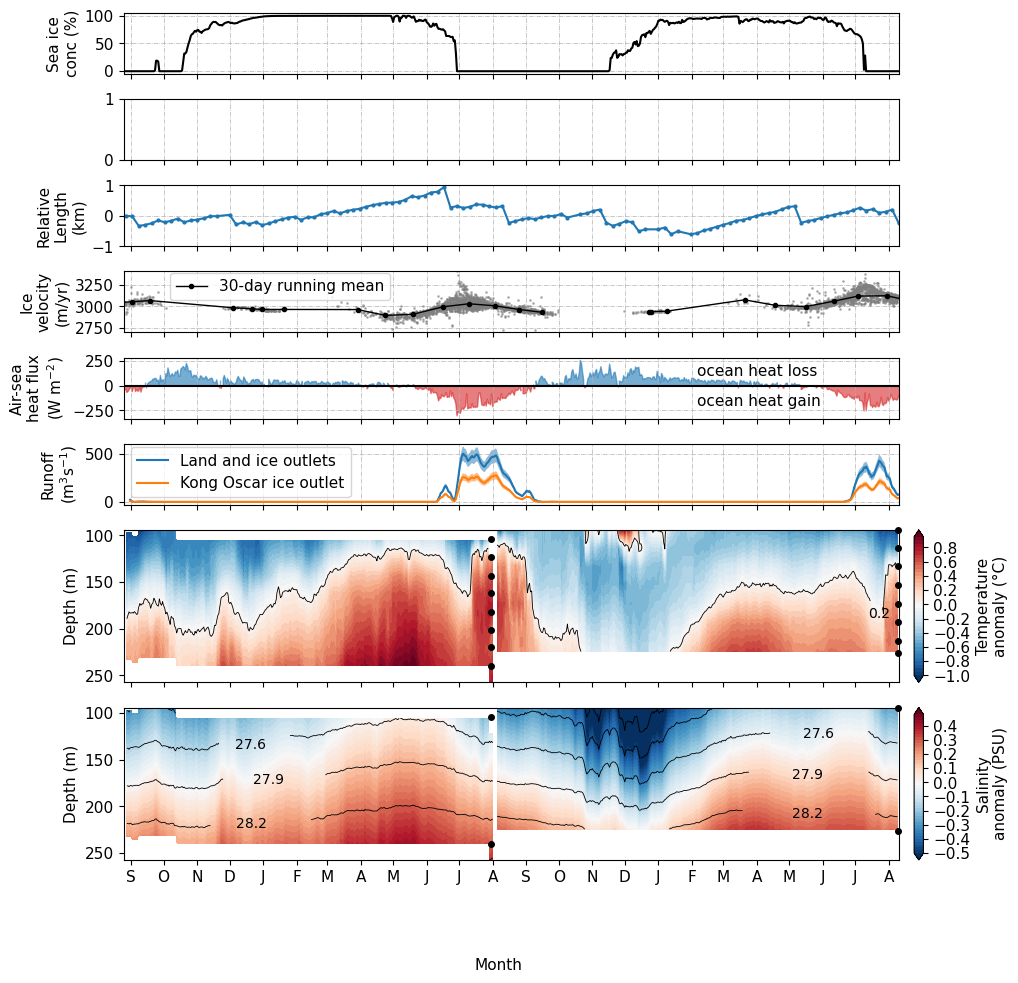

In [61]:
#### set up figure with subplots #### =================================
plt.rcParams['font.size'] = '11'
fig, axs = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False, figsize=[10,11], gridspec_kw={'height_ratios': [0.2,0.2,0.2,0.2,0.2,0.2,0.5,0.5]})
(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = axs.ravel()
plt.subplots_adjust(wspace=0.1, hspace=0.15)

## adjust spacing between subplots
plt.subplots_adjust(hspace=0.3)

## add grid lines to upper 6 panels
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax.grid(linestyle='-.', linewidth=0.5)

#### plot sea ice #### =================================
# (ice_baffinbay_1d_avg.siconc*100).plot(ax=ax1, c='tab:gray', label = "N Baffin Bay")
# (ice_KO.siconc*100).plot(ax=ax1, c='black', label = "Fjord")
(ice_KO.siconc*100).plot(ax=ax1, c='black')
# ax1.legend()

#### plot vertical velocity #### =================================



#### plot glacier length #### =================================
ko_terminus_trunc_da = ko_terminus_da.sel(time=slice("2018-08-25","2020-08-10"))
(ko_terminus_trunc_da-ko_terminus_trunc_da.isel(time=0)).plot(ax=ax3,marker='o', markersize=2)

#### plot ice velocity #### =================================
ko_vel_ds_filter.velocity.plot(ax=ax4,marker='o',linestyle='', markersize=1, alpha=0.5, c='tab:gray')
ax4.plot(ts_ko,runmean_ko, color='k', marker='.', linewidth=1, label='30-day running mean')
ax4.legend(bbox_to_anchor=(0.05, 1.1), loc='upper left')

#### plot air-sea heat flux #### =================================
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values>0), color='tab:blue', alpha=0.6)
ax5.fill_between(Q_net_watts_ko.time, Q_net_watts_ko.values, 0, where=(Q_net_watts_ko.values<0), color='tab:red', alpha=0.6)
ax5.axhline(y=0, color='k', linestyle='-')
ax5.text(np.datetime64("2020-02-06"), 100, 'ocean heat loss', fontsize = 11)
ax5.text(np.datetime64("2020-02-06"), -200, 'ocean heat gain', fontsize = 11)

#### plot runoff #### =================================
## plot 7-day running mean for all lang and ice outlets within KO fjord
KO_racmo_7d = KO_racmo_ds.sel(time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['station','basin_type']).rolling(time=7).mean()
KO_racmo_7d.plot(ax=ax6, label='Land and ice outlets')
## plot for only KO glacier ice outlet
KO_glacier_racmo_7d = KO_racmo_ds.sel(station=31202,time=slice("2018-08-25","2020-08-10")).discharge.sum(dim=['basin_type']).rolling(time=7).mean()
KO_glacier_racmo_7d.plot(ax=ax6, label='Kong Oscar ice outlet')
ax6.legend()
# add 15% error
ax6.fill_between(KO_racmo_7d.time.values, KO_racmo_7d+KO_racmo_7d*0.15, KO_racmo_7d-KO_racmo_7d*0.15, alpha=0.5)
ax6.fill_between(KO_glacier_racmo_7d.time.values, KO_glacier_racmo_7d+KO_glacier_racmo_7d*0.15, KO_glacier_racmo_7d-KO_glacier_racmo_7d*0.15, alpha=0.5)

#### plot profiles #### =================================
## set levels
levels_temp=np.arange(-1,1,0.05)
levels_salt=np.arange(-0.5,0.5,0.02)

## plot
temp = (KO_temp_interp_ds.temperature-KO_temp_interp_ds.temperature.mean()).plot.contourf(ax=ax7, cmap='RdBu_r', levels=levels_temp,add_colorbar=False, extend='both')
salt = (KO_salt_interp_ds.salinity-KO_salt_interp_ds.salinity.mean()).plot.contourf(ax=ax8, cmap='RdBu_r',levels=levels_salt,add_colorbar=False, extend='both')

## add isotherm at mean temp value
cs = KO_temp_interp_ds.temperature.plot.contour(ax=ax7,levels=[KO_temp_interp_ds.temperature.mean().values], colors='black', linewidths=0.6)
cl = ax7.clabel(cs, fontsize=10, fmt='%.1f',manual=[(18400,200)])
for l in cl:l.set_rotation(0)

## add potential density contour lines and their labels
cs = KO_dens_interp_ds.density.plot.contour(ax=ax8,colors='black', linewidths=0.6)
manual_locations = [(17900,220),(17900,170),(17900,140),(18400,120),(18400,170),(18400,240)]
cl = ax8.clabel(cs, fontsize=10, fmt='%.1f',manual=manual_locations)
for l in cl:l.set_rotation(0)

## add colorbars
axins = inset_axes(ax7,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax7.transAxes,
    borderpad=0)
fig.colorbar(temp,cax=axins,label='Temperature\nanomaly (°C)')
axins = inset_axes(ax8,
    width="1.2%",  # width: 5% of parent_bbox width
    height="100%",
    loc="upper left",
    bbox_to_anchor=(1.02, 0., 1, 1),
    bbox_transform=ax8.transAxes,
    borderpad=0)
fig.colorbar(salt,cax=axins,label='Salinity\nanomaly (PSU)')

#### adjust axes settings #### =================================
## set limits
ax3.set_ylim(-1,1)
ax4.set_ylim(2700,3400)
ax7.set_ylim(KO_temp_interp_ds.depth.max(),KO_temp_interp_ds.depth.min())
ax8.set_ylim(KO_salt_interp_ds.depth.max(),KO_salt_interp_ds.depth.min())
ax8.set_xlim([np.datetime64("2018-08-25"),np.datetime64("2020-08-10")])

## add axis labels and ticks
ax1.set_ylabel("Sea ice\nconc (%)")
ax1.set_yticks([0,50,100])
ax3.set_ylabel("Relative\nLength\n(km)")
ax4.set_ylabel("Ice\nvelocity\n(m/yr)")
ax5.set_ylabel("Air-sea\nheat flux\n(W m$^{-2}$)")
ax6.set_ylabel("Runoff\n(m$^3$s$^{-1}$)")
ax7.set_ylabel("Depth (m)")
ax8.set_ylabel("Depth (m)")

## lower axis label
months   = pd.period_range(np.datetime64('2018-09'), freq='M', periods=24).strftime('%Y-%m').tolist()
abbrev = ["S","O",'N','D',"J",'F','M','A','M','J','J','A',"S","O",'N','D',"J",'F','M','A','M','J','J','A']
ax8.set_xticks(months, abbrev, rotation=0, horizontalalignment = 'center')
ax8.set_xlabel("")
fig.text(0.5, 0.01, 'Month', size=11, ha='center')

for ax in (ax1,ax2,ax3,ax4,ax5,ax6,ax7):
    ax.set_xlabel("")
    ax.set_title("")

#### add sensor depths #### =================================
ax7.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.Depth_temp))), kongoscar19.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)
ax7.plot(list(itertools.repeat(kongoscar20.time[-1].values, len(kongoscar20.Depth_temp))), kongoscar20.Depth_temp.values,"o", color='black', markersize=4, clip_on=False)

ax8.plot(list(itertools.repeat(kongoscar19.time[-5].values, len(kongoscar19.Depth_CTD))), kongoscar19.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False)
ax8.plot(list(itertools.repeat(kongoscar20.time[-1].values, len(kongoscar20.Depth_CTD))), kongoscar20.Depth_CTD.values,"o", color='black', markersize=4, clip_on=False);

# plt.savefig("figures/kong-oscar_subplots.png", bbox_inches="tight")